In [114]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
import json
import math
from hole_data import hole_data, post_hole_data
from dataclasses import dataclass
from sklearn.cluster import DBSCAN
from scipy.optimize import least_squares
from scipy.optimize import minimize

Simulation

In [116]:
# Function to calculate the endpoints of a mirror given center, length, and angle
def calculate_mirror_endpoints(center, length, angle):
    half_length = length / 2
    angle_rad = np.radians(angle)
    start = (
        center[0] - half_length * np.cos(angle_rad),
        center[1] - half_length * np.sin(angle_rad),
    )
    end = (
        center[0] + half_length * np.cos(angle_rad),
        center[1] + half_length * np.sin(angle_rad),
    )
    return start, end

# Function to find the intersection of two lines
def find_intersection(p1, p2, p3, p4, eps=1e-9):
    # Laser direction (t parameter)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    r = np.array([x2 - x1, y2 - y1], dtype=float)  # laser direction
    s = np.array([x4 - x3, y4 - y3], dtype=float)  # mirror direction

    rxs = r[0]*s[1] - r[1]*s[0]
    if abs(rxs) < eps:
        return None  # parallel / nearly parallel

    qp = np.array([x3 - x1, y3 - y1], dtype=float)

    # Solve p1 + t r = p3 + u s
    t = (qp[0]*s[1] - qp[1]*s[0]) / rxs
    u = (qp[0]*r[1] - qp[1]*r[0]) / rxs

    # Mirror segment constraint: u in [0, 1]
    # Laser ray constraint: t >= 0 (in front of start)
    if t >= -eps and -eps <= u <= 1 + eps:
        return (x1 + t*r[0], y1 + t*r[1])

    return None

# Function to calculate the reflection of a laser beam
def reflect_laser(laser_start, laser_angle, mirrors, last_mirror):
    laser_angle_rad = np.radians(laser_angle)
    laser_far_end = (
        laser_start[0] + np.cos(laser_angle_rad) * 1000,
        laser_start[1] + np.sin(laser_angle_rad) * 1000,
    )
    
    closest_intersection = None
    closest_mirror = None
    min_distance = float('inf')

    # Find the closest intersection, ignoring the last mirror hit
    for mirror in mirrors:
        if mirror == last_mirror:
            continue
        intersection = find_intersection(laser_start, laser_far_end, mirror[0], mirror[1])
        if intersection is not None:
            distance = np.linalg.norm(np.array(intersection) - np.array(laser_start))
            if distance < min_distance:
                min_distance = distance
                closest_intersection = intersection
                closest_mirror = mirror

    if closest_intersection is None:
        return None, None, None  # No reflection
    
    # Reflection calculation
    mirror_start, mirror_end = closest_mirror
    mirror_vector = np.array([mirror_end[0] - mirror_start[0], mirror_end[1] - mirror_start[1]])
    mirror_length = np.linalg.norm(mirror_vector)
    mirror_unit_vector = mirror_vector / mirror_length
    normal_vector = np.array([-mirror_unit_vector[1], mirror_unit_vector[0]])
    incident_vector = np.array([closest_intersection[0] - laser_start[0], closest_intersection[1] - laser_start[1]])
    reflection_vector = (
        incident_vector - 2 * np.dot(incident_vector, normal_vector) * normal_vector
    )
    reflected_end = (
        closest_intersection[0] + reflection_vector[0],
        closest_intersection[1] + reflection_vector[1],
    )
    return closest_intersection, reflected_end, closest_mirror

In [117]:
# Function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Simulate laser reflections with length calculation
def simulate_laser_with_length(laser_start, laser_angle, mirrors, max_reflections=36):
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    laser_path = [laser_start]  # Track laser path

    for _ in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections; add final endpoint and break
            laser_far_end = (
                current_position[0] + np.cos(np.radians(current_angle)) * 1000,
                current_position[1] + np.sin(np.radians(current_angle)) * 1000,
            )
            laser_path.append(laser_far_end)
            break

        # Update the path and continue simulation
        laser_path.append(intersection)
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    # Calculate total laser length
    total_length = sum(calculate_distance(laser_path[i], laser_path[i + 1]) for i in range(len(laser_path) - 2))
    return laser_path, total_length

def extend_line(p1, p2):
    # Calculate the length of the line
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    # Extend the line in both directions
    new_p1 = (p1[0] - 0.73*dx, p1[1] - 0.73*dy)  # Extend p1 backwards
    new_p2 = (p2[0] + 0.73*dx, p2[1] + 0.73*dy)  # Extend p2 forwards
    return new_p1, new_p2

def create_orthogonal_line_at_endpoint(endpoint, other_endpoint, length=44):
    """Create an orthogonal line of the specified length at a given endpoint."""
    # Calculate the direction vector of the original line
    dx = other_endpoint[0] - endpoint[0]
    dy = other_endpoint[1] - endpoint[1]
    
    # Get orthogonal direction
    orthogonal_dx = -dy
    orthogonal_dy = dx
    magnitude = np.sqrt(orthogonal_dx**2 + orthogonal_dy**2)
    unit_dx = orthogonal_dx / magnitude
    unit_dy = orthogonal_dy / magnitude

    # Compute the two endpoints of the orthogonal line
    ortho_p1 = (endpoint[0] + unit_dx * length, endpoint[1] + unit_dy * length)
    ortho_p2 = (endpoint[0] - unit_dx * length, endpoint[1] - unit_dy * length)
    return ortho_p1, ortho_p2

def select_furthest_orthogonal_line(endpoint, ortho_p1, ortho_p2, reference_x=100):
    """Select the orthogonal line endpoint furthest away from reference_x."""
    # Calculate distances from reference_x for each orthogonal endpoint
    dist_ortho_p1 = abs(ortho_p1[0] - reference_x)
    dist_ortho_p2 = abs(ortho_p2[0] - reference_x)
    
    # Return the endpoint further from reference_x
    if dist_ortho_p1 > dist_ortho_p2:
        return (endpoint, ortho_p1)
    else:
        return (endpoint, ortho_p2)

def process_mirrors(mirrors):
    doubled_lines = []
    orthogonal_lines = []
    
    for p1, p2 in mirrors:
        # Double the length of the original line
        extended_p1, extended_p2 = extend_line(p1, p2)
        doubled_lines.append((extended_p1, extended_p2))

        # Create orthogonal lines at the endpoints of the doubled line
        ortho_p1_a, ortho_p1_b = create_orthogonal_line_at_endpoint(extended_p1, extended_p2)
        ortho_p2_a, ortho_p2_b = create_orthogonal_line_at_endpoint(extended_p2, extended_p1)
        
        # Select only the orthogonal line furthest from x=100
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p1, ortho_p1_a, ortho_p1_b))
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p2, ortho_p2_a, ortho_p2_b))

    return doubled_lines, orthogonal_lines

In [118]:
# The diameter of usable mirror. Given 1 inch mirror: 25.4mm. Clear aperture from spec sheet: 22.9mm.
# 3mm diameter beam. 22.9 - (3/2) = 21.4 mm
mirror_lengths = [21.4, 21.4, 21.4, 21.4]

# Set up the laser
laser_start = (0, 100)
laser_angle = 0  # Initial laser angle in degrees

In [119]:
#Quad Cell Locations
qc_1 = np.array([-100, 137])
qc_2 = np.array([-300, 190])

In [120]:
def execution(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    # Initialize plot
    plt.figure(figsize=(12, 10))
    plt.scatter(*laser_start, color='red', label="Laser Source", linewidth=1)

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Draw the mirrors
    for i, mirror in enumerate(mirrors):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], color = 'black', linewidth=3)

    #Draw piezo mirror mounts outline for fitting purposes
    for i, mirror in enumerate(doubled_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    for i, mirror in enumerate(orthogonal_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1, color = 'black')

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    reflection_count = 0

    for i in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections
            plt.plot(
                [current_position[0], current_position[0] + np.cos(np.radians(current_angle)) * 1000],
                [current_position[1], current_position[1] + np.sin(np.radians(current_angle)) * 1000],
                'g--'
            )
            break

        # Draw the laser and reflection
        plt.plot([current_position[0], intersection[0]], [current_position[1], intersection[1]], 'r-', linewidth =1)
        #plt.plot([intersection[0], reflected_end[0]], [intersection[1], reflected_end[1]], 'g-')
        #plt.scatter(*intersection, color='orange', label=f"Intersection {i+1}")
    
        # Update for next reflection
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror
        reflection_count += 1

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    #Identify if the exiting beam gets clipped with M4
    a = np.array([a[0], a[1]])
    b = np.array([b[0], b[1]])
    m = np.array([m4cx, m4cy])
    v = b - a
    d = np.array([np.cos(np.deg2rad(m4a)), np.sin(np.deg2rad(m4a))])
    A = np.column_stack((v, -d))
    t, s = np.linalg.solve(A, m - a)
    if 0 <= t <= 1:
        p = a + t * v
        dist = np.linalg.norm(p - m)
    else:
        # Beam does not pass near M4 — no clipping possible
        print("Beam does not intersect M4 region")
        dist = np.inf

    if dist >= 14.3: # Mirror diameter = 25.4mm. laser beam diameter = 3mm. (25.4/2) + (3/2) + 0.1(<- additional edge of mirror error)
        print("NOT CLIPPED, room to spare: ", dist-14.3, "mm")
    else:
        print("CLIPPED, ", dist-14.3, 'mm too much')
        
    print("Laser Path:", laser_path)
    print("Total Laser Length:", total_length+distance, "mm")
    print("Total Number of Reflection (N_R) = ", reflection_count)

    # Finalize plot
    plt.xlim(-310, 250)
    plt.ylim(-10, 210)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Laser Reflection with Multiple Mirrors")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.grid(True, linewidth=0.3)
    plt.plot([qc_1[0],qc_1[0]],[qc_1[1] - 2, qc_1[1] + 2], linewidth=4, label='QC1') # Quadcell Detector 1
    plt.plot([qc_2[0],qc_2[0]],[qc_2[1] - 2, qc_2[1] + 2], linewidth=4, label='QC2') # Quadcell Detector 2
    plt.legend(prop={'size': 8})
    plt.show()

In [121]:
def execution_reflec(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    """
    Simulates the laser path and returns a list of coordinates for each reflection point.
    Output: [(x0, y0), (x1, y1), ... (xn, yn)]
    """
    # 1. Setup Mirror Endpoints
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a]
    
    mirrors = []
    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    # 2. Simulation Loop
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    
    # Initialize path with the starting point
    path = [current_position]

    for _ in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(
            current_position, current_angle, mirrors, last_mirror
        )
        
        if intersection is None:
            # Optional: Add one final point far in the distance to show the exit beam
            exit_dist = 1000
            final_x = current_position[0] + np.cos(np.radians(current_angle)) * exit_dist
            final_y = current_position[1] + np.sin(np.radians(current_angle)) * exit_dist
            path.append((final_x, final_y))
            break

        # Append the reflection point
        path.append(intersection)
        
        # Update for next reflection
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    return path

In [122]:
def execution_identifier(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    last_two = laser_path[-2:]
    exit_slope = (last_two[1][1]-last_two[0][1])/(last_two[1][0]-last_two[0][0])
    y_int=last_two[1][1]-exit_slope*last_two[1][0]
    y100=exit_slope*-100+y_int
    y200=exit_slope*-200+y_int
    y300=exit_slope*-300+y_int
    y525=exit_slope*-525+y_int
    print(f"Exit angle: {exit_slope}")
    print(f"Total length: {total_length + distance}")
    print(f"y100: {y100-137}")
    print(f"y200: {y200-163.5}")
    print(f"y300: {y300-190}")
    print(f"y525: {y525-249.63}")

    return exit_slope, total_length + distance, y100-137, y300-190

Camera Calibration

In [124]:
intrinsics_path = r"C:\Users\alber\Documents\hardware_project\intrinsics_fisheye.json"

with open(intrinsics_path, "r") as f:
    intr = json.load(f)

K = np.array(intr["K"], dtype=np.float64)
D = np.array(intr["D"], dtype=np.float64)  # shape (N,1) or (1,N) is fine
img_w = intr["image_width"]
img_h = intr["image_height"]

In [125]:
obj_xyz = []
img_uv  = []

# Table holes: Z = 0
for X, Y, u, v in hole_data:
    obj_xyz.append([X, Y, 0.0])
    img_uv.append([u, v])

# Post tops: Z = H
for X, Y, u, v, H in post_hole_data:
    obj_xyz.append([X, Y, H])
    img_uv.append([u, v])

obj_xyz = np.array(obj_xyz, dtype=np.float64)
img_uv  = np.array(img_uv,  dtype=np.float64)

print("Using", obj_xyz.shape[0], "points for pose estimation.")

success, rvec_cw, tvec_cw = cv.solvePnP(
    objectPoints=obj_xyz,
    imagePoints=img_uv,
    cameraMatrix=K,
    distCoeffs=D,
    flags=cv.SOLVEPNP_ITERATIVE
)

if not success:
    raise RuntimeError("solvePnP failed")

R_cw, _ = cv.Rodrigues(rvec_cw)  # world -> camera
t_cw = tvec_cw                   # 3x1

R_wc = R_cw.T                    # camera -> world
t_wc = -R_wc @ t_cw              # camera center in world coords

Using 160 points for pose estimation.


Transition Functions

In [127]:
def pixel_to_world_on_plane(u, v, H_in=0.0, override_cam_height=None):
    pts = np.array([[[u, v]]], dtype=np.float64)
    rays_norm = cv.undistortPoints(pts, K, D)  # pinhole model
    x, y = rays_norm[0,0]
    d_cam = np.array([x, y, 1.0], dtype=np.float64)

    d_w = R_wc @ d_cam

    C_w = t_wc.reshape(3).copy()
    if override_cam_height is not None:
        C_w[2] = float(override_cam_height)

    lam = (H_in - C_w[2]) / d_w[2]
    Pw = C_w + lam * d_w
    return float(Pw[0]), float(Pw[1])

In [128]:
def world_to_pixel(X, Y, Z):
    obj = np.array([[[X, Y, Z]]], dtype=np.float64)  # (1,1,3)
    img_proj, _ = cv.projectPoints(obj, rvec_cw, tvec_cw, K, D)
    u, v = img_proj.reshape(2)
    return float(u), float(v)

In [129]:
def sim_to_pt(loc_x, loc_y):
    # Calibration constants from your original function
    calib_irl = [-2.65720102, -0.94574237]
    calib_sim = [-160, -109]

    # 1. Reverse the negation
    # Since: loc_x = -(diff_x + calib_sim[0])
    # Then:  -loc_x - calib_sim[0] = diff_x
    diff_x = -loc_x - calib_sim[0]
    diff_y = -loc_y - calib_sim[1]

    # 2. Reverse the scaling (25.4) and the IRL offset subtraction
    # Since: diff_x = (x - calib_irl[0]) * 25.4
    # Then:  x = (diff_x / 25.4) + calib_irl[0]
    x = (diff_x / 25.4) + calib_irl[0]
    y = (diff_y / 25.4) + calib_irl[1]

    return x, y

In [130]:
def get_mount_corners(x, y, z, theta_deg):
    """
    Calculates the 3 corners of a mirror mount given the center (x,y,z) 
    and rotation theta, applying quadrant-specific discarding and sorting.
    """
    # Convert angle to radians
    theta = np.radians(theta_deg)
    center = np.array([float(x), float(y), float(z)])
    s_half = 1.3 / 2
    
    # 1. Define unit vectors for the mirror plane
    # u is horizontal (in x-y plane), v is vertical (z-axis)
    u = np.array([np.cos(theta), np.sin(theta), 0.0])
    v = np.array([0.0, 0.0, 1.0])
    
    # 2. Calculate all 4 possible corners of the 1.3" square
    corners = [
        center + s_half*u + s_half*v,
        center + s_half*u - s_half*v,
        center - s_half*u + s_half*v,
        center - s_half*u - s_half*v
    ]
    
    # 3. Determine reference point and sort criteria based on (x, y) signs
    # Logic: (ref_point, first_sort_attr, first_sort_reverse, third_sort_attr, third_sort_reverse)
    # attr: 1 for y, 2 for z. reverse=True for "largest", False for "smallest".
    if x < 0 and y < 0:
        ref = np.array([-3.0, 0.0, 5.0])
        # Largest Z first, Largest Y third
        config = {'first': (2, True), 'third': (1, True)}
    elif x < 0 and y >= 0:
        ref = np.array([-4.0, 0.0, 0.0])
        # Smallest Y first, Smallest Z third
        config = {'first': (1, False), 'third': (2, False)}
    elif x >= 0 and y >= 0:
        ref = np.array([4.0, 0.0, 0.0])
        # Smallest Z first, Smallest Y third
        config = {'first': (2, False), 'third': (1, False)}
    else: # x >= 0 and y < 0
        ref = np.array([3.0, 0.0, 5.0])
        # Largest Y first, Largest Z third
        config = {'first': (1, True), 'third': (2, True)}
        
    # 4. Discard the corner closest to the reference point
    distances = [np.linalg.norm(c - ref) for c in corners]
    discard_idx = np.argmin(distances)
    remaining = [corners[i] for i in range(4) if i != discard_idx]
    
    # 5. Sort the remaining 3 corners based on the quadrant's rules
    # Get the corner for the 'first' position
    idx_f, rev_f = config['first']
    out1 = sorted(remaining, key=lambda c: c[idx_f], reverse=rev_f)[0]
    
    # Get the remaining two to find the 'third' position
    others = [c for c in remaining if not np.array_equal(c, out1)]
    idx_t, rev_t = config['third']
    out3 = sorted(others, key=lambda c: c[idx_t], reverse=rev_t)[0]
    
    # The last one is the 'second' position
    out2 = [c for c in others if not np.array_equal(c, out3)][0]
    
    return [out1, out2, out3]

Sim + ArUcos

In [133]:
lsr_height = 4.087 #inches

M1y, M2y, M3y, M4y = 109, 75, 71, 117 # simulation units (mm)

In [134]:
def sim_to_px_reflec(x, y): # For reflection points
    sim_M_IRL = sim_to_pt(x, y)
    pixel_point = world_to_pixel(sim_M_IRL[0], sim_M_IRL[1], lsr_height)
    return pixel_point

In [135]:
def sim_to_px(x, y, a): # For ArUcos
    sim_M_IRL = sim_to_pt(x, y)
    sim_M_corners = get_mount_corners(sim_M_IRL[0], sim_M_IRL[1], lsr_height, a)
    sim_M_corner_1 = world_to_pixel(sim_M_corners[0][0], sim_M_corners[0][1], sim_M_corners[0][2])
    sim_M_corner_2 = world_to_pixel(sim_M_corners[1][0], sim_M_corners[1][1], sim_M_corners[1][2])
    sim_M_corner_3 = world_to_pixel(sim_M_corners[2][0], sim_M_corners[2][1], sim_M_corners[2][2])
    return sim_M_corner_1, sim_M_corner_2, sim_M_corner_3

In [166]:
def sim_to_image(M1, M2, M3, M4, img_path):
    M1x, M1y, M1a = M1
    M2x, M2y, M2a = M2
    M3x, M3y, M3a = M3
    M4x, M4y, M4a = M4

    reflecs_list = execution_reflec(
        M1x, M1y,
        M2x, M2y,
        M3x, M3y,
        M4x, M4y,
        M1a, M2a, M3a, M4a
    )
    reflecs_sim = reflecs_list[1:-1]
    reflecs_px = [sim_to_px_reflec(x, y) for x, y in reflecs_sim]

    M1_IRL = sim_to_pt(M1x,M1y)
    M2_IRL = sim_to_pt(M2x,M2y)
    M3_IRL = sim_to_pt(M3x,M3y)
    M4_IRL = sim_to_pt(M4x,M4y)
    
    ArUcos_IRL = {
        "M1": get_mount_corners(M1_IRL[0], M1_IRL[1], lsr_height, M1a),
        "M2": get_mount_corners(M2_IRL[0], M2_IRL[1], lsr_height, M2a),
        "M3": get_mount_corners(M3_IRL[0], M3_IRL[1], lsr_height, M3a),
        "M4": get_mount_corners(M4_IRL[0], M4_IRL[1], lsr_height, M4a),
    }

    ArUcos_px = {
        mid: [world_to_pixel(p[0], p[1], p[2]) for p in corners]
        for mid, corners in ArUcos_IRL.items()
    }

    # ===================== PLOTTING ===========================

    img = mpimg.imread(img_path)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    ax.set_title("ArUcos + Reflections Overlay")

    # Plot reflections (red)
    if reflecs_px:
        rx, ry = zip(*reflecs_px)
        ax.scatter(
            rx, ry,
            facecolors="none", edgecolors="red",
            s=60, linewidths=2,
            marker="o",
            label="Reflections"
        )

    # Plot ArUcos (different color per mirror)
    colors = {"M1": "cyan", "M2": "yellow", "M3": "lime", "M4": "magenta"}

    for mid, pts in ArUcos_px.items():
        xs, ys = zip(*pts)
        ax.scatter(
            xs, ys,
            c=colors[mid],
            s=120, linewidths=2.5,
            marker="+",
            label=mid
        )

    # Image coordinates: origin top-left
    ax.set_xlim(0, img.shape[1])
    ax.set_ylim(img.shape[0], 0)

    ax.legend()
    ax.set_xlabel("x [px]")
    ax.set_ylabel("y [px]")
    plt.tight_layout()
    plt.show()

    return ArUcos_px, reflecs_px

In [137]:
# Example mirror parameters:
M1 = [160, 109, 96.8312]
M2 = [20, 75, 96.9015]
M3 = [180, 71, 81.919]
M4 = [40, 117, 81.119]

NOT CLIPPED, room to spare:  2.3206922094099056 mm
Laser Path: [(0, 100), (161.07815591882658, 100.0), (21.092683891285475, 65.97252847346545), (179.34132220181854, 66.3608607973605), (38.52275910844779, 107.54602702559015), (160.5465957431594, 104.43724464844698), (21.00123554760816, 66.72805102237442), (178.87741465806064, 63.09350963023574), (-787.75309758636, 319.26816254907726)]
Total Laser Length: 1219.6913894315412 mm
Total Number of Reflection (N_R) =  7


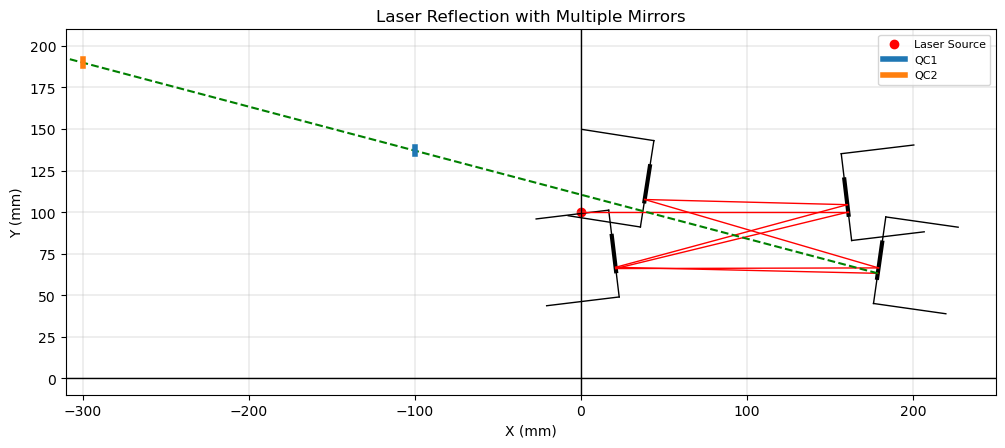

In [138]:
execution(M1[0], M1[1], #M1, (x,y)
          M2[0], M2[1], #M2, (x,y)
          M3[0], M3[1], #M3, (x,y)
          M4[0], M4[1], #M4, (x,y)
          M1[2], M2[2], M3[2], M4[2]) # Angle from positive x-axis (M1, M2, M3, M4)

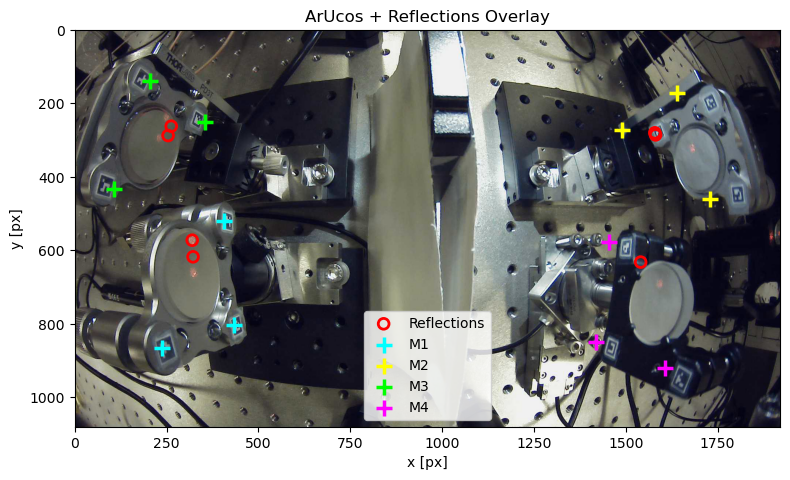

({'M1': [(238.50475126116157, 865.661028955426),
   (433.4959940452342, 803.4500572872615),
   (405.2025530900861, 520.9064755711764)],
  'M2': [(1489.4911144746648, 272.787957615768),
   (1639.657089832986, 170.51153914286743),
   (1730.0277857572532, 459.3674910012859)],
  'M3': [(106.04169297623969, 432.45694988187677),
   (205.44017066989306, 137.93818667378866),
   (355.56790340383714, 250.89984947347494)],
  'M4': [(1455.3739095164326, 577.3978882864305),
   (1418.8077746822328, 849.2946142263777),
   (1606.1143025633455, 919.6060879115257)]},
 [(319.7146628928524, 572.2549027211306),
  (1579.3007597976248, 279.7954426443247),
  (254.00959325540873, 287.30415220525106),
  (1540.6793305719066, 631.8207176010008),
  (322.02194365707396, 617.4328906394354),
  (1581.2271364858334, 285.5111806940422),
  (262.6080101328273, 261.8878300763464)])

In [141]:
sim_to_image(M1, M2, M3, M4, img_path = 'N1L.jpg')